In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Load data
df = pd.read_csv("data/ESS11.csv", sep=";", encoding="utf-8",
                usecols=["idno", "respc19a", "vacc19",	"cntry",
                        "eisced","hinctnta", "hhmmb", "netusoft",
                        "gndr", "maritalb", "domicil", "agea", "trstprl",
                        "trstlgl", "trstplc", "trstplt", "trstprt"])

In [4]:
# Show basic structure
print("Shape of the data:", df.shape)

Shape of the data: (46162, 17)


In [5]:
# Display first five rows
df

,idno,respc19a,vacc19,cntry,eisced,hinctnta,hhmmb,netusoft,gndr,maritalb,domicil,agea,trstprl,trstlgl,trstplc,trstplt,trstprt
0,50014,1.0,1.0,AT,3.0,6.0,2.0,5.0,1,1.0,3.0,65.0,6.0,9.0,10.0,5.0,5.0
1,50030,1.0,1.0,AT,5.0,1.0,1.0,5.0,2,6.0,1.0,21.0,6.0,6.0,4.0,1.0,0.0
2,50057,1.0,1.0,AT,6.0,5.0,3.0,5.0,2,1.0,3.0,53.0,7.0,5.0,8.0,4.0,4.0
3,50106,1.0,1.0,AT,5.0,2.0,1.0,1.0,2,4.0,1.0,78.0,5.0,6.0,9.0,3.0,3.0
4,50145,3.0,1.0,AT,3.0,NaN,2.0,5.0,1,1.0,4.0,64.0,6.0,8.0,8.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46157,86379,1.0,1.0,SK,2.0,5.0,3.0,5.0,1,6.0,4.0,18.0,4.0,5.0,10.0,3.0,3.0
46158,86407,3.0,1.0,SK,4.0,7.0,2.0,2.0,1,1.0,1.0,56.0,4.0,7.0,10.0,4.0,6.0
46159,86408,1.0,1.0,SK,7.0,10.0,3.0,5.0,2,1.0,4.0,31.0,5.0,4.0,5.0,5.0,5.0
46160,86426,3.0,2.0,SK,1.0,NaN,7.0,5.0,1,6.0,4.0,15.0,0.0,5.0,2.0,3.0,NaN


In [6]:
df.isna().sum()

idno           0
respc19a     540
vacc19       342
cntry          0
eisced       188
hinctnta    9847
hhmmb        327
netusoft      42
gndr           0
maritalb     743
domicil      101
agea         357
trstprl      916
trstlgl      976
trstplc      451
trstplt      698
trstprt      840
dtype: int64

In [7]:
df = df[df['cntry'] == 'DE']
print("Length of the Germany data:", df.shape)
df.isna().sum()

Length of the Germany data: (2420, 17)


idno          0
respc19a     13
vacc19        9
cntry         0
eisced       14
hinctnta    251
hhmmb         2
netusoft      0
gndr          0
maritalb     12
domicil       2
agea          5
trstprl      18
trstlgl      19
trstplc       6
trstplt      19
trstprt      29
dtype: int64

Dependent variable encoding

The variable vacc19 tells us whether someone has received at least one COVID-19 vaccination dose. People could answer:

1 = Yes

2 = No

7 = Refusal to answer

8 = Don’t know

9 = No answer

Since we want to model who actually got vaccinated versus who did not, it makes sense to treat:

1 → vaccinated (coded as 1)

2 → not vaccinated (coded as 0)

The other responses (7, 8, 9) do not give us any meaningful information. They just mean the person refused, didn’t know, or skipped the question. Therefore, we should treat them as missing values and remove those rows from the analysis.

In simple words, if people refused to answer, we cannot know their vaccination status — so we have to drop those rows.

In [8]:
# Recode vacc19
df = df[df['vacc19'].isin([1, 2])]  # keep only valid responses
df['vacc19_binary'] = df['vacc19'].map({1: 1, 2: 0})

Research Question:
Which demographic, socioeconomic, and attitudinal factors influenced COVID-19 vaccination uptake in Germany in 2023?

In [9]:
# Recode respc19a as binary (1 = ever infected, 0 = never infected)
df = df[df['respc19a'].isin([1, 2, 3])]
df['respc19a_binary'] = df['respc19a'].map({1: 1, 2: 1, 3: 0})

In [10]:
df['gndr'] = df['gndr'].replace({1: 0, 2: 1})

In [11]:
df

,idno,respc19a,vacc19,cntry,eisced,hinctnta,hhmmb,netusoft,gndr,maritalb,domicil,agea,trstprl,trstlgl,trstplc,trstplt,trstprt,vacc19_binary,respc19a_binary
8256,50004,1.0,1.0,DE,6.0,9.0,2.0,5.0,0,6.0,3.0,34.0,7.0,7.0,8.0,5.0,5.0,1,1
8257,50032,1.0,1.0,DE,7.0,3.0,4.0,5.0,1,6.0,4.0,42.0,4.0,8.0,8.0,5.0,3.0,1,1
8258,50052,1.0,1.0,DE,3.0,NaN,5.0,5.0,0,1.0,1.0,41.0,8.0,7.0,8.0,7.0,7.0,1,1
8259,50059,1.0,1.0,DE,3.0,8.0,2.0,5.0,1,4.0,2.0,58.0,7.0,8.0,8.0,8.0,7.0,1,1
8260,50070,3.0,1.0,DE,7.0,10.0,5.0,5.0,0,1.0,1.0,40.0,7.0,8.0,9.0,7.0,7.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10671,86394,1.0,2.0,DE,2.0,10.0,2.0,5.0,1,6.0,1.0,21.0,2.0,1.0,1.0,3.0,3.0,0,1
10672,86463,3.0,1.0,DE,7.0,10.0,2.0,5.0,1,6.0,2.0,29.0,3.0,6.0,9.0,2.0,3.0,1,0
10673,86466,1.0,1.0,DE,3.0,8.0,2.0,5.0,1,1.0,2.0,58.0,2.0,5.0,7.0,0.0,1.0,1,1
10674,86474,3.0,1.0,DE,6.0,5.0,2.0,5.0,1,4.0,4.0,40.0,9.0,10.0,9.0,7.0,5.0,1,0


In [12]:
# -----------------------------------------
# 1. Variables with missing codes {7, 8, 9}
# -----------------------------------------
vars_789 = ['netusoft', 'domicil']
for var in vars_789:
    df = df[~df[var].isin([7,8,9])]

# -----------------------------------------
# 2. Variables with missing codes {77, 88, 99}
# -----------------------------------------
vars_778899 = ['maritalb', 'hinctnta', 'hhmmb',
            'trstprl', 'trstlgl', 'trstplc', 'trstplt', 'trstprt']
for var in vars_778899:
    df = df[~df[var].isin([77,88,99])]

# -----------------------------------------
# 3. Variables with missing codes {7, 8, 9, 77, 88, 99}
# (if any variable had all of these, we could use this, but none does here)
# so we skip this group for now

# -----------------------------------------
# 4. Variables with specific missing codes
# -----------------------------------------

# gender (only 9 means missing)
df = df[df['gndr'] != 9]

# education level (more specific)
df = df[~df['eisced'].isin([55,77,88,99])]

# age (999 means missing)
df = df[df['agea'] != 999]

# country does not need cleaning (mandatory)

# -----------------------------------------
# show cleaned data
# -----------------------------------------
df

,idno,respc19a,vacc19,cntry,eisced,hinctnta,hhmmb,netusoft,gndr,maritalb,domicil,agea,trstprl,trstlgl,trstplc,trstplt,trstprt,vacc19_binary,respc19a_binary
8256,50004,1.0,1.0,DE,6.0,9.0,2.0,5.0,0,6.0,3.0,34.0,7.0,7.0,8.0,5.0,5.0,1,1
8257,50032,1.0,1.0,DE,7.0,3.0,4.0,5.0,1,6.0,4.0,42.0,4.0,8.0,8.0,5.0,3.0,1,1
8258,50052,1.0,1.0,DE,3.0,NaN,5.0,5.0,0,1.0,1.0,41.0,8.0,7.0,8.0,7.0,7.0,1,1
8259,50059,1.0,1.0,DE,3.0,8.0,2.0,5.0,1,4.0,2.0,58.0,7.0,8.0,8.0,8.0,7.0,1,1
8260,50070,3.0,1.0,DE,7.0,10.0,5.0,5.0,0,1.0,1.0,40.0,7.0,8.0,9.0,7.0,7.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10671,86394,1.0,2.0,DE,2.0,10.0,2.0,5.0,1,6.0,1.0,21.0,2.0,1.0,1.0,3.0,3.0,0,1
10672,86463,3.0,1.0,DE,7.0,10.0,2.0,5.0,1,6.0,2.0,29.0,3.0,6.0,9.0,2.0,3.0,1,0
10673,86466,1.0,1.0,DE,3.0,8.0,2.0,5.0,1,1.0,2.0,58.0,2.0,5.0,7.0,0.0,1.0,1,1
10674,86474,3.0,1.0,DE,6.0,5.0,2.0,5.0,1,4.0,4.0,40.0,9.0,10.0,9.0,7.0,5.0,1,0


When some people do not report their household income, it is like a blank spot in the survey. If you simply throw away all those people, you might lose a lot of data (10% in this case). But you also do not want to just make up random numbers.

Using the median to fill in those blanks is reasonable because: a. the median is the “middle” income group, so it is robust to extremely rich or poor people; b. it does not get pulled upward or downward by outliers; c. it gives you a realistic estimate for someone “typical” in the sample

So you are filling in the blanks with a “middle of the road” reasonable value that will not distort your model too much.

In [13]:
df.isnull().sum()

idno                 0
respc19a             0
vacc19               0
cntry                0
eisced              12
hinctnta           242
hhmmb                2
netusoft             0
gndr                 0
maritalb            11
domicil              2
agea                 5
trstprl             18
trstlgl             18
trstplc              5
trstplt             18
trstprt             29
vacc19_binary        0
respc19a_binary      0
dtype: int64

In [14]:
df['hinctnta'] = df['hinctnta'].fillna(df['hinctnta'].median())

In [15]:
df = df.dropna()

In [16]:
df.isnull().sum()

idno               0
respc19a           0
vacc19             0
cntry              0
eisced             0
hinctnta           0
hhmmb              0
netusoft           0
gndr               0
maritalb           0
domicil            0
agea               0
trstprl            0
trstlgl            0
trstplc            0
trstplt            0
trstprt            0
vacc19_binary      0
respc19a_binary    0
dtype: int64

In [17]:
df.to_csv("data/ESS11_de_cleaned.csv", index=False, sep=";")

Question 4: linear combination check

In [18]:
ctab = None

In [19]:
# check cross-tabulations for each categorical variable before fitting:
for var in ['gndr', 'maritalb', 'domicil', 'cntry', 'eisced', "respc19a_binary",
            "trstprl", "trstlgl", "trstplc", "trstplt", "trstprt"]:
    ctab = pd.crosstab(df[var], df['vacc19_binary'])
    print(f"\nCross-tabulation for {var}:\n", ctab)



Cross-tabulation for gndr:
 vacc19_binary    0     1
gndr                    
0               73  1102
1              105  1043

Cross-tabulation for maritalb:
 vacc19_binary   0     1
maritalb               
1.0            83  1179
2.0             2    10
4.0            11   185
5.0             6   134
6.0            76   637

Cross-tabulation for domicil:
 vacc19_binary   0    1
domicil               
1.0            21  380
2.0            19  289
3.0            60  683
4.0            70  748
5.0             8   45

Cross-tabulation for cntry:
 vacc19_binary    0     1
cntry                   
DE             178  2145

Cross-tabulation for eisced:
 vacc19_binary   0    1
eisced                
1.0             8   30
2.0            28  144
3.0            66  805
4.0            12  100
5.0            30  509
6.0            12  198
7.0            22  359

Cross-tabulation for respc19a_binary:
 vacc19_binary      0     1
respc19a_binary           
0                 58   666
1            

Excluding the "trst-" predictors as some of those provide perfect separation
whereas those which do not provide perfect separation, provide very little evidences which
might lead to bias towards one prediction

check if non-linearity exists

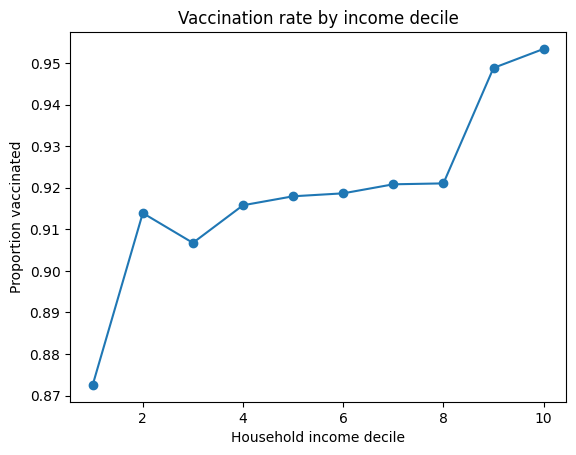

In [20]:
# get vaccination rate by income decile
vacc_rates = df.groupby('hinctnta')['vacc19_binary'].mean()

# plot
plt.plot(vacc_rates.index, vacc_rates.values, marker='o')
plt.xlabel('Household income decile')
plt.ylabel('Proportion vaccinated')
plt.title('Vaccination rate by income decile')
plt.show()


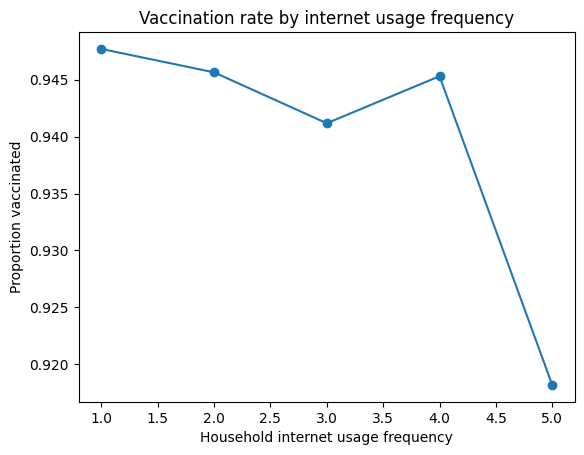

In [21]:
# get vaccination rate by income decile
vacc_rates = df.groupby('netusoft')['vacc19_binary'].mean()

# plot
plt.plot(vacc_rates.index, vacc_rates.values, marker='o')
plt.xlabel('Household internet usage frequency')
plt.ylabel('Proportion vaccinated')
plt.title('Vaccination rate by internet usage frequency')
plt.show()


In [22]:
# Assuming df is still loaded from previous cleaning steps

# Redefine the list of predictors
predictors = [
    'agea',
    'respc19a_binary',
    'hinctnta',
    'hhmmb',
    'netusoft',
    'gndr',
    'trstprl', 
    'trstlgl', 
    'trstplc', 
    'trstplt'
]

In [23]:
# Dummy code relevant categorical variables
df = pd.get_dummies(df, columns=['maritalb', 'domicil', 'eisced'], drop_first=True)

# Add all dummies to predictors
predictors += [col for col in df.columns if any(x in col for x in ['maritalb_', 'domicil_', 'eisced_'])]

print("Predictors after dummy coding:\n", predictors)
# Make sure there are no non-numeric columns:
for col in predictors:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# # Remove any rows with NA (if missing)
# df_model = df.dropna(subset=predictors + ['vacc19_binary'])
# Drop missing rows
df_model = df.dropna(subset=predictors + ['vacc19_binary'])

Predictors after dummy coding:
 ['agea', 'respc19a_binary', 'hinctnta', 'hhmmb', 'netusoft', 'gndr', 'trstprl', 'trstlgl', 'trstplc', 'trstplt', 'maritalb_2.0', 'maritalb_4.0', 'maritalb_5.0', 'maritalb_6.0', 'domicil_2.0', 'domicil_3.0', 'domicil_4.0', 'domicil_5.0', 'eisced_2.0', 'eisced_3.0', 'eisced_4.0', 'eisced_5.0', 'eisced_6.0', 'eisced_7.0']


In [24]:
# Create design matrix
X = df_model[predictors]
X = sm.add_constant(X)

# Response variable
y = df_model['vacc19_binary']

# Confirm again that X is fully numeric
print(X.dtypes)

# Fit the model
logit_model = sm.Logit(y, X.astype(float))
result = logit_model.fit()

const              float64
agea               float64
respc19a_binary      int64
hinctnta           float64
hhmmb              float64
netusoft           float64
gndr                 int64
trstprl            float64
trstlgl            float64
trstplc            float64
trstplt            float64
maritalb_2.0          bool
maritalb_4.0          bool
maritalb_5.0          bool
maritalb_6.0          bool
domicil_2.0           bool
domicil_3.0           bool
domicil_4.0           bool
domicil_5.0           bool
eisced_2.0            bool
eisced_3.0            bool
eisced_4.0            bool
eisced_5.0            bool
eisced_6.0            bool
eisced_7.0            bool
dtype: object
Optimization terminated successfully.
         Current function value: 0.235945
         Iterations 7


In [25]:
# Print the summary
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:          vacc19_binary   No. Observations:                 2323
Model:                          Logit   Df Residuals:                     2298
Method:                           MLE   Df Model:                           24
Date:                Sun, 06 Jul 2025   Pseudo R-squ.:                  0.1276
Time:                        22:37:16   Log-Likelihood:                -548.10
converged:                       True   LL-Null:                       -628.25
Covariance Type:            nonrobust   LLR p-value:                 3.945e-22
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.8108      0.934     -0.868      0.385      -2.641       1.020
agea                0.0269      0.008      3.422      0.001       0.011       0.042
respc19a_binary    -0.0273      

In [26]:
# You can also get odds ratios:
odds_ratios = pd.Series(np.exp(result.params), name="Odds Ratio")
print("\nOdds Ratios:\n", odds_ratios)


Odds Ratios:
 const              0.444524
agea               1.027214
respc19a_binary    0.973085
hinctnta           1.106114
hhmmb              0.934647
netusoft           0.935970
gndr               0.671512
trstprl            1.064730
trstlgl            1.087227
trstplc            1.091295
trstplt            1.145522
maritalb_2.0       0.427497
maritalb_4.0       1.384463
maritalb_5.0       1.165162
maritalb_6.0       1.103547
domicil_2.0        0.656838
domicil_3.0        0.560069
domicil_4.0        0.486864
domicil_5.0        0.188877
eisced_2.0         1.405048
eisced_3.0         2.682232
eisced_4.0         2.162663
eisced_5.0         3.117614
eisced_6.0         2.659521
eisced_7.0         1.697311
Name: Odds Ratio, dtype: float64


### Model Selection

Several variables were not statistically significant (p > 0.05), including household size, internet use, gender, marital status dummies, trust in parliament, and trust in the legal system.

Retaining non-significant variables increases model complexity without adding explanatory power.

A simpler, more parsimonious model would be clearer for interpretation and more stable.

In [36]:
# initialize design matrix
X = df[predictors]
X = sm.add_constant(X)

# backward selection loop
current_predictors = X.columns.tolist()

while True:
    model = sm.Logit(y, X[current_predictors].astype(float)).fit(disp=0)
    pvalues = model.pvalues.drop('const')
    max_p = pvalues.max()
    if max_p > 0.05:
        worst_predictor = pvalues.idxmax()
        print(f"Dropping {worst_predictor} with p-value {max_p:.4f}")
        current_predictors.remove(worst_predictor)
    else:
        break

# final model
final_model = sm.Logit(y, X[current_predictors].astype(float)).fit()
print(final_model.summary())

# odds ratios
odds_ratios = pd.Series(np.exp(final_model.params), name="Odds Ratio")
print("\nOdds Ratios:\n", odds_ratios)

Dropping respc19a_binary with p-value 0.8834
Dropping maritalb_5.0 with p-value 0.7487
Dropping maritalb_6.0 with p-value 0.7075
Dropping eisced_2.0 with p-value 0.5039
Dropping eisced_7.0 with p-value 0.5064
Dropping netusoft with p-value 0.4978
Dropping maritalb_4.0 with p-value 0.4739
Dropping maritalb_2.0 with p-value 0.2710
Dropping eisced_4.0 with p-value 0.2509
Dropping domicil_2.0 with p-value 0.2436
Dropping trstprl with p-value 0.2519
Dropping eisced_6.0 with p-value 0.1439
Dropping hhmmb with p-value 0.0886
Dropping trstplc with p-value 0.0695
Dropping domicil_3.0 with p-value 0.0766
Dropping eisced_3.0 with p-value 0.0695
Dropping eisced_5.0 with p-value 0.1111
Dropping domicil_4.0 with p-value 0.0711
Optimization terminated successfully.
         Current function value: 0.242000
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          vacc19_binary   No. Observations:                 2323
Model:           